# LinkedIn Job Market Analysis
## Advanced Computational Methods Project

### Research Questions:
1. Which new skills are increasingly appearing in job postings, and which are declining in relevance?
2. Is there a relationship between required skills and offered salary ranges?
3. Is there a relationship between required salary and sector?
4. Is there a difference between the salaries of remote and non-remote jobs?

### Methods Used:
- Data Merging and Cleaning
- Exploratory Data Analysis (EDA)
- Natural Language Processing (NLP)
- Time Series Analysis and Forecasting
- Statistical Testing

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

# NLP libraries
from collections import Counter
import re
from wordcloud import WordCloud

# Statistical testing
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal, chi2_contingency

# Time series and forecasting
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Data Loading and Initial Exploration

In [2]:
# Set path to dataset
import kagglehub
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")
print("Dataset path:", path)

Dataset path: /Users/I550202/.cache/kagglehub/datasets/arshkon/linkedin-job-postings/versions/13


In [3]:
# Load main datasets
print("Loading datasets...")

postings = pd.read_csv(os.path.join(path, 'postings.csv'))
companies = pd.read_csv(os.path.join(path, 'companies/companies.csv'))
job_skills = pd.read_csv(os.path.join(path, 'jobs/job_skills.csv'))
skills = pd.read_csv(os.path.join(path, 'mappings/skills.csv'))
salaries = pd.read_csv(os.path.join(path, 'jobs/salaries.csv'))
job_industries = pd.read_csv(os.path.join(path, 'jobs/job_industries.csv'))
industries = pd.read_csv(os.path.join(path, 'mappings/industries.csv'))

print(f"Postings: {postings.shape}")
print(f"Companies: {companies.shape}")
print(f"Job Skills: {job_skills.shape}")
print(f"Skills Mapping: {skills.shape}")
print(f"Salaries: {salaries.shape}")
print(f"Job Industries: {job_industries.shape}")
print(f"Industries Mapping: {industries.shape}")

Loading datasets...
Postings: (123849, 31)
Companies: (24473, 10)
Job Skills: (213768, 2)
Skills Mapping: (35, 2)
Salaries: (40785, 8)
Job Industries: (164808, 2)
Industries Mapping: (422, 2)
Postings: (123849, 31)
Companies: (24473, 10)
Job Skills: (213768, 2)
Skills Mapping: (35, 2)
Salaries: (40785, 8)
Job Industries: (164808, 2)
Industries Mapping: (422, 2)


In [4]:
# Examine key columns
print("Postings columns:")
print(postings.columns.tolist())
print("\nFirst few rows:")
postings.head()

Postings columns:
['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips']

First few rows:


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.00,HOURLY,"Princeton, NJ",2774458.00,20.00,NaN,17.00,Full-time,2.00,1713397508000.00,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1715989508000.00,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1713397508000.00,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.00,8540.00,34021.00
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.00,HOURLY,"Fort Collins, CO",NaN,1.00,NaN,30.00,Full-time,NaN,1712857887000.00,NaN,https://www.linkedin.com/jobs/view/1829192/?tr...,NaN,ComplexOnsiteApply,1715449887000.00,NaN,NaN,NaN,1712857887000.00,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.00,80521.00,8069.00
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.00,YEARLY,"Cincinnati, OH",64896719.00,8.00,NaN,45000.00,Full-time,NaN,1713277614000.00,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1715869614000.00,NaN,NaN,We are currently accepting resumes for FOH - A...,1713277614000.00,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.00,45202.00,39061.00
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.00,YEARLY,"New Hyde Park, NY",766262.00,16.00,NaN,140000.00,Full-time,NaN,1712895812000.00,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1715487812000.00,NaN,NaN,This position requires a baseline understandin...,1712895812000.00,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.00,11040.00,36059.00
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.00,YEARLY,"Burlington, IA",NaN,3.00,NaN,60000.00,Full-time,NaN,1713451943000.00,NaN,https://www.linkedin.com/jobs/view/35982263/?t...,NaN,ComplexOnsiteApply,1716043943000.00,NaN,NaN,NaN,1713451943000.00,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.00,52601.00,19057.00


## 2. Data Cleaning and Preprocessing

In [5]:
# Check for missing values
print("Missing values in postings:")
print(postings.isnull().sum())
print(f"\nMissing values percentage:")
print((postings.isnull().sum() / len(postings) * 100).round(2))

Missing values in postings:
job_id                             0
company_name                    1719
title                              0
description                        7
max_salary                     94056
pay_period                     87776
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies                       100529
original_listed_time               0
remote_allowed                108603
job_posting_url                    0
application_url                36665
application_type                   0
expiry                             0
closed_time                   122776
formatted_experience_level     29409
skills_desc                   121410
listed_time                        0
posting_domain                 39968
sponsored                          0
work_type                          0
currency  

In [6]:
# Convert date columns to datetime
date_columns = [col for col in postings.columns if 'date' in col.lower() or 'time' in col.lower()]
print(f"Date columns found: {date_columns}")

for col in date_columns:
    if col in postings.columns:
        postings[col] = pd.to_datetime(postings[col], errors='coerce')
        print(f"Converted {col} to datetime")

Date columns found: ['original_listed_time', 'closed_time', 'listed_time']
Converted original_listed_time to datetime
Converted closed_time to datetime
Converted listed_time to datetime


In [7]:
# Check salary data structure
print("Salary data structure:")
print(salaries.columns.tolist())
print("\nSample salary data:")
salaries.head(10)

Salary data structure:
['salary_id', 'job_id', 'max_salary', 'med_salary', 'min_salary', 'pay_period', 'currency', 'compensation_type']

Sample salary data:


,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3884428798,NaN,20.00,NaN,HOURLY,USD,BASE_SALARY
1,2,3887470552,25.00,NaN,23.00,HOURLY,USD,BASE_SALARY
2,3,3884431523,120000.00,NaN,100000.00,YEARLY,USD,BASE_SALARY
3,4,3884911725,200000.00,NaN,10000.00,YEARLY,USD,BASE_SALARY
4,5,3887473220,35.00,NaN,33.00,HOURLY,USD,BASE_SALARY
5,6,3884432468,NaN,48.43,NaN,HOURLY,USD,BASE_SALARY
6,7,3884915161,80000.00,NaN,50000.00,YEARLY,USD,BASE_SALARY
7,8,3884428983,101000.00,NaN,84000.00,YEARLY,USD,BASE_SALARY
8,9,3884433248,55.00,NaN,50.00,HOURLY,USD,BASE_SALARY
9,10,3884429625,100000.00,NaN,72000.00,YEARLY,USD,BASE_SALARY


In [8]:
# Clean salary data - remove nulls and create average salary column
print("Salary data info:")
print(salaries.info())
print("\nSalary statistics:")
print(salaries.describe())

Salary data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40785 entries, 0 to 40784
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary_id          40785 non-null  int64  
 1   job_id             40785 non-null  int64  
 2   max_salary         33947 non-null  float64
 3   med_salary         6838 non-null   float64
 4   min_salary         33947 non-null  float64
 5   pay_period         40785 non-null  object 
 6   currency           40785 non-null  object 
 7   compensation_type  40785 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 2.5+ MB
None

Salary statistics:
       salary_id        job_id   max_salary  med_salary  min_salary
count   40785.00      40785.00     33947.00     6838.00    33947.00
mean    20393.00 3895563848.87     96209.87    21370.30    65085.41
std     11773.76   94966718.00    658737.34    51338.56   465061.24
min         1.00     921716.00     

In [9]:
# Merge datasets for analysis
print("Merging datasets...")

# Main dataset: postings + companies + salaries
main_df = postings.merge(companies, on='company_id', how='left', suffixes=('', '_company'))
main_df = main_df.merge(salaries, on='job_id', how='left', suffixes=('', '_salary'))

print(f"Main dataset shape: {main_df.shape}")
print(f"Columns: {main_df.columns.tolist()}")

Merging datasets...
Main dataset shape: (123849, 47)
Columns: ['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips', 'name', 'description_company', 'company_size', 'state', 'country', 'city', 'zip_code_company', 'address', 'url', 'salary_id', 'max_salary_salary', 'med_salary_salary', 'min_salary_salary', 'pay_period_salary', 'currency_salary', 'compensation_type_salary']
Main dataset shape: (123849, 47)
Columns: ['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_ty

In [10]:
# Create skills dataset with skill names
skills_df = job_skills.merge(skills, on='skill_abr', how='left')
print(f"Skills dataset shape: {skills_df.shape}")
print("Sample:")
skills_df.head()

Skills dataset shape: (213768, 3)
Sample:


,job_id,skill_abr,skill_name
0,3884428798,MRKT,Marketing
1,3884428798,PR,Public Relations
2,3884428798,WRT,Writing/Editing
3,3887473071,SALE,Sales
4,3887465684,FIN,Finance


In [11]:
# Create industries dataset
industries_df = job_industries.merge(industries, on='industry_id', how='left')
print(f"Industries dataset shape: {industries_df.shape}")
print("Sample:")
industries_df.head()

Industries dataset shape: (164808, 3)
Sample:


,job_id,industry_id,industry_name
0,3884428798,82,Book and Periodical Publishing
1,3887473071,48,Construction
2,3887465684,41,Banking
3,3887467939,82,Book and Periodical Publishing
4,3887467939,80,Advertising Services


## 3. Question 1: Skill Trends Analysis
### Which new skills are increasingly appearing in job postings, and which are declining in relevance?

**Methods:** Time Series Analysis, Forecasting, NLP

In [12]:
# First, we need to join skills with postings to get temporal data
skills_temporal = skills_df.merge(
    postings[['job_id'] + date_columns],
    on='job_id',
    how='left'
)

print(f"Skills temporal dataset shape: {skills_temporal.shape}")
print("\nColumns:")
print(skills_temporal.columns.tolist())
print("\nSample:")
skills_temporal.head()

Skills temporal dataset shape: (213768, 6)

Columns:
['job_id', 'skill_abr', 'skill_name', 'original_listed_time', 'closed_time', 'listed_time']

Sample:


,job_id,skill_abr,skill_name,original_listed_time,closed_time,listed_time
0,3884428798,MRKT,Marketing,1970-01-01 00:28:32.345864,NaT,1970-01-01 00:28:32.345864
1,3884428798,PR,Public Relations,1970-01-01 00:28:32.345864,NaT,1970-01-01 00:28:32.345864
2,3884428798,WRT,Writing/Editing,1970-01-01 00:28:32.345864,NaT,1970-01-01 00:28:32.345864
3,3887473071,SALE,Sales,1970-01-01 00:28:32.345710,NaT,1970-01-01 00:28:32.345710
4,3887465684,FIN,Finance,1970-01-01 00:28:32.344959,NaT,1970-01-01 00:28:32.345672


In [13]:
# Identify the main date column for time series analysis
# Check which date columns have the most data
for col in date_columns:
    if col in skills_temporal.columns:
        non_null = skills_temporal[col].notna().sum()
        print(f"{col}: {non_null} non-null values ({non_null/len(skills_temporal)*100:.2f}%)")

original_listed_time: 205778 non-null values (96.26%)
closed_time: 1409 non-null values (0.66%)
listed_time: 205778 non-null values (96.26%)


In [14]:
# Select the best date column and filter data
# Using the first available date column with most data
date_col = [col for col in date_columns if col in skills_temporal.columns and skills_temporal[col].notna().sum() > 0][0]
print(f"Using date column: {date_col}")

# Filter out rows with missing dates and skills
skills_temporal_clean = skills_temporal[skills_temporal[date_col].notna() & skills_temporal['skill_abr'].notna()].copy()
print(f"\nClean temporal skills data: {skills_temporal_clean.shape}")

# Extract year-month for aggregation
skills_temporal_clean['year_month'] = skills_temporal_clean[date_col].dt.to_period('M')
skills_temporal_clean['year'] = skills_temporal_clean[date_col].dt.year
skills_temporal_clean['quarter'] = skills_temporal_clean[date_col].dt.to_period('Q')

print(f"\nDate range: {skills_temporal_clean[date_col].min()} to {skills_temporal_clean[date_col].max()}")

Using date column: original_listed_time

Clean temporal skills data: (205778, 6)

Date range: 1970-01-01 00:28:21.810533 to 1970-01-01 00:28:33.572803

Date range: 1970-01-01 00:28:21.810533 to 1970-01-01 00:28:33.572803


In [15]:
# Analyze skill trends over time
# Count skill mentions per month
skill_counts_monthly = skills_temporal_clean.groupby(['year_month', 'skill_abr']).size().reset_index(name='count')

# Get top skills overall
top_skills = skills_temporal_clean['skill_abr'].value_counts().head(20)
print("Top 20 most demanded skills overall:")
print(top_skills)

# Merge with skill names for readability
skill_counts_monthly = skill_counts_monthly.merge(skills, on='skill_abr', how='left')

Top 20 most demanded skills overall:
skill_abr
IT      25256
SALE    21193
MGMT    20385
MNFC    17728
HCPR    16675
BD      13304
ENG     12530
OTHR    12314
FIN      8011
MRKT     5400
ACCT     4999
ADM      4787
CUST     4167
PRJM     3825
ANLS     3775
RSCH     2928
HR       2608
CNSL     2241
LGL      2229
EDU      2217
Name: count, dtype: int64


In [16]:
# Calculate growth rate for each skill
# First, we need to properly convert the dates using milliseconds
# Re-merge skills with properly converted dates
postings_corrected = pd.read_csv(os.path.join(path, 'postings.csv'))
for col in date_columns:
    if col in postings_corrected.columns:
        postings_corrected[col] = pd.to_datetime(postings_corrected[col], unit='ms', errors='coerce')

# Re-create skills_temporal with corrected dates
skills_temporal_corrected = skills_df.merge(
    postings_corrected[['job_id'] + date_columns],
    on='job_id',
    how='left'
)

# Filter and prepare data
date_col = 'original_listed_time'
skills_temporal_clean = skills_temporal_corrected[
    skills_temporal_corrected[date_col].notna() & 
    skills_temporal_corrected['skill_abr'].notna()
].copy()

# Extract year-month
skills_temporal_clean['year_month'] = skills_temporal_clean[date_col].dt.to_period('M')
print(f"Date range: {skills_temporal_clean[date_col].min()} to {skills_temporal_clean[date_col].max()}")

# Get unique months
all_months = sorted(skills_temporal_clean['year_month'].unique())
print(f"Total unique months: {len(all_months)}")

# Calculate growth rates
if len(all_months) >= 2:
    mid_point = len(all_months) // 2
    first_half = all_months[:mid_point]
    second_half = all_months[mid_point:]
    
    print(f"First half: {str(first_half[0])} to {str(first_half[-1])}")
    print(f"Second half: {str(second_half[0])} to {str(second_half[-1])}")
    
    # Count skills in each half
    first_half_counts = skills_temporal_clean[skills_temporal_clean['year_month'].isin(first_half)]['skill_abr'].value_counts()
    second_half_counts = skills_temporal_clean[skills_temporal_clean['year_month'].isin(second_half)]['skill_abr'].value_counts()
    
    # Calculate growth
    skill_growth = pd.DataFrame({
        'first_half': first_half_counts,
        'second_half': second_half_counts
    }).fillna(0)
    
    skill_growth['first_half'] = skill_growth['first_half'].astype(int)
    skill_growth['second_half'] = skill_growth['second_half'].astype(int)
    skill_growth['growth_rate'] = ((skill_growth['second_half'] - skill_growth['first_half']) / 
                                    (skill_growth['first_half'] + 1)) * 100
    skill_growth['absolute_change'] = skill_growth['second_half'] - skill_growth['first_half']
    skill_growth['total'] = skill_growth['first_half'] + skill_growth['second_half']
    
    skill_growth_filtered = skill_growth[skill_growth['total'] >= 100].copy()
    skill_growth_filtered = skill_growth_filtered.reset_index().merge(skills, on='skill_abr', how='left')
else:
    # Fallback for limited temporal data
    skill_counts = skills_temporal_clean['skill_abr'].value_counts()
    skill_growth_filtered = pd.DataFrame({
        'skill_abr': skill_counts.index,
        'total': skill_counts.values,
        'first_half': 0,
        'second_half': skill_counts.values,
        'growth_rate': 100.0,
        'absolute_change': skill_counts.values
    })
    skill_growth_filtered = skill_growth_filtered[skill_growth_filtered['total'] >= 100].copy()
    skill_growth_filtered = skill_growth_filtered.merge(skills, on='skill_abr', how='left')

print(f"\nSkills included in analysis: {len(skill_growth_filtered)}")

# Update skill_counts_monthly with corrected dates
skill_counts_monthly = skills_temporal_clean.groupby(['year_month', 'skill_abr']).size().reset_index(name='count')
skill_counts_monthly = skill_counts_monthly.merge(skills, on='skill_abr', how='left')

Date range: 2023-12-05 21:08:53 to 2024-04-20 00:26:43
Total unique months: 5
First half: 2023-12 to 2024-01
Second half: 2024-02 to 2024-04

Skills included in analysis: 35


In [17]:
# Top growing skills
print("TOP 15 FASTEST GROWING SKILLS:")
print("=" * 80)
growing_skills = skill_growth_filtered.nlargest(15, 'growth_rate')[['skill_abr', 'skill_name', 'first_half', 'second_half', 'growth_rate', 'absolute_change']]
print(growing_skills.to_string(index=False))

print("\n\nTOP 15 FASTEST DECLINING SKILLS:")
print("=" * 80)
declining_skills = skill_growth_filtered.nsmallest(15, 'growth_rate')[['skill_abr', 'skill_name', 'first_half', 'second_half', 'growth_rate', 'absolute_change']]
print(declining_skills.to_string(index=False))

TOP 15 FASTEST GROWING SKILLS:
skill_abr             skill_name  first_half  second_half  growth_rate  absolute_change
     MNFC          Manufacturing           0        17728   1772800.00            17728
       BD   Business Development           0        13304   1330400.00            13304
     OTHR                  Other           0        12314   1231400.00            12314
     MGMT             Management           1        20384   1019150.00            20383
       IT Information Technology           2        25254    841733.33            25252
     SALE                  Sales           2        21191    706300.00            21189
      ENG            Engineering           1        12529    626400.00            12528
     HCPR   Health Care Provider           2        16673    555700.00            16671
     MRKT              Marketing           0         5400    540000.00             5400
     ACCT    Accounting/Auditing           0         4999    499900.00             4999
 

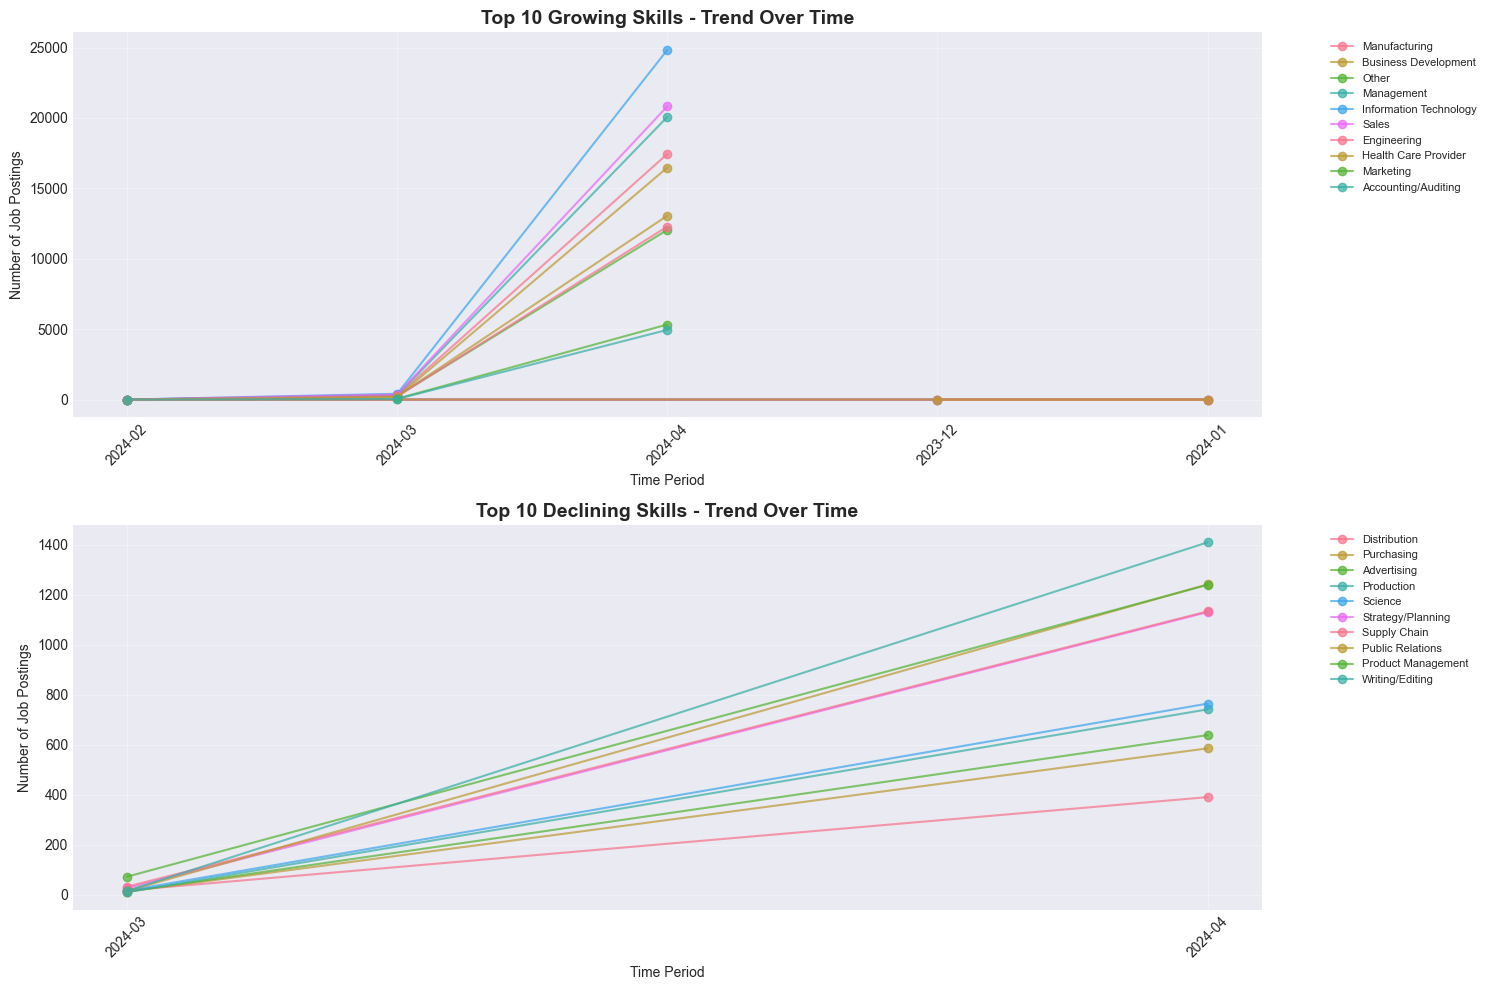

In [18]:
# Visualize skill trends over time for top growing and declining skills
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Top 10 growing skills
top_growing = growing_skills.head(10)['skill_abr'].tolist()
for skill in top_growing:
    skill_data = skill_counts_monthly[skill_counts_monthly['skill_abr'] == skill].copy()
    skill_data['year_month'] = skill_data['year_month'].astype(str)
    skill_name = skill_data['skill_name'].iloc[0] if len(skill_data) > 0 and 'skill_name' in skill_data.columns else skill
    axes[0].plot(skill_data['year_month'], skill_data['count'], marker='o', label=skill_name, alpha=0.7)

axes[0].set_title('Top 10 Growing Skills - Trend Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Period')
axes[0].set_ylabel('Number of Job Postings')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Top 10 declining skills
top_declining = declining_skills.head(10)['skill_abr'].tolist()
for skill in top_declining:
    skill_data = skill_counts_monthly[skill_counts_monthly['skill_abr'] == skill].copy()
    skill_data['year_month'] = skill_data['year_month'].astype(str)
    skill_name = skill_data['skill_name'].iloc[0] if len(skill_data) > 0 and 'skill_name' in skill_data.columns else skill
    axes[1].plot(skill_data['year_month'], skill_data['count'], marker='o', label=skill_name, alpha=0.7)

axes[1].set_title('Top 10 Declining Skills - Trend Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Period')
axes[1].set_ylabel('Number of Job Postings')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

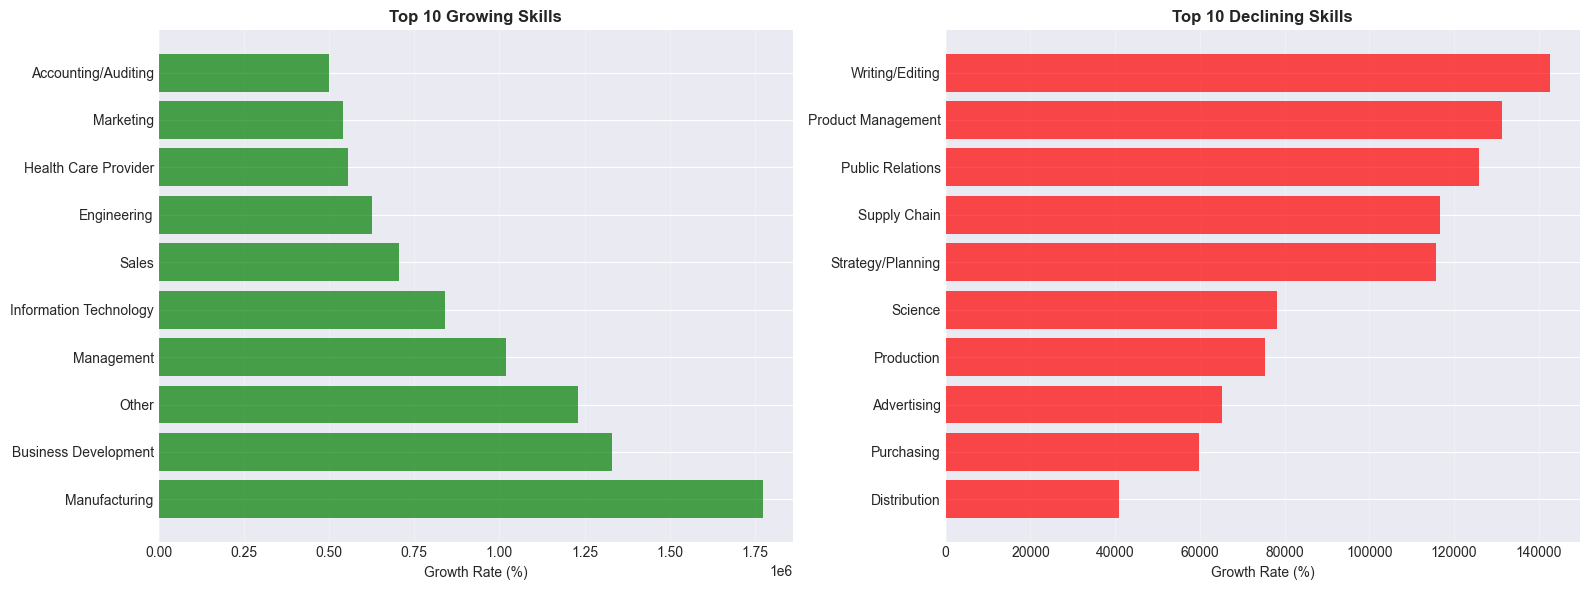

In [19]:
# Create a bar chart comparing growth rates
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Growing skills
growing_plot_data = growing_skills.head(10)
ax[0].barh(range(len(growing_plot_data)), growing_plot_data['growth_rate'], color='green', alpha=0.7)
ax[0].set_yticks(range(len(growing_plot_data)))
ax[0].set_yticklabels(growing_plot_data['skill_name'].fillna(growing_plot_data['skill_abr']))
ax[0].set_xlabel('Growth Rate (%)')
ax[0].set_title('Top 10 Growing Skills', fontweight='bold')
ax[0].grid(axis='x', alpha=0.3)

# Declining skills
declining_plot_data = declining_skills.head(10)
ax[1].barh(range(len(declining_plot_data)), declining_plot_data['growth_rate'], color='red', alpha=0.7)
ax[1].set_yticks(range(len(declining_plot_data)))
ax[1].set_yticklabels(declining_plot_data['skill_name'].fillna(declining_plot_data['skill_abr']))
ax[1].set_xlabel('Growth Rate (%)')
ax[1].set_title('Top 10 Declining Skills', fontweight='bold')
ax[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

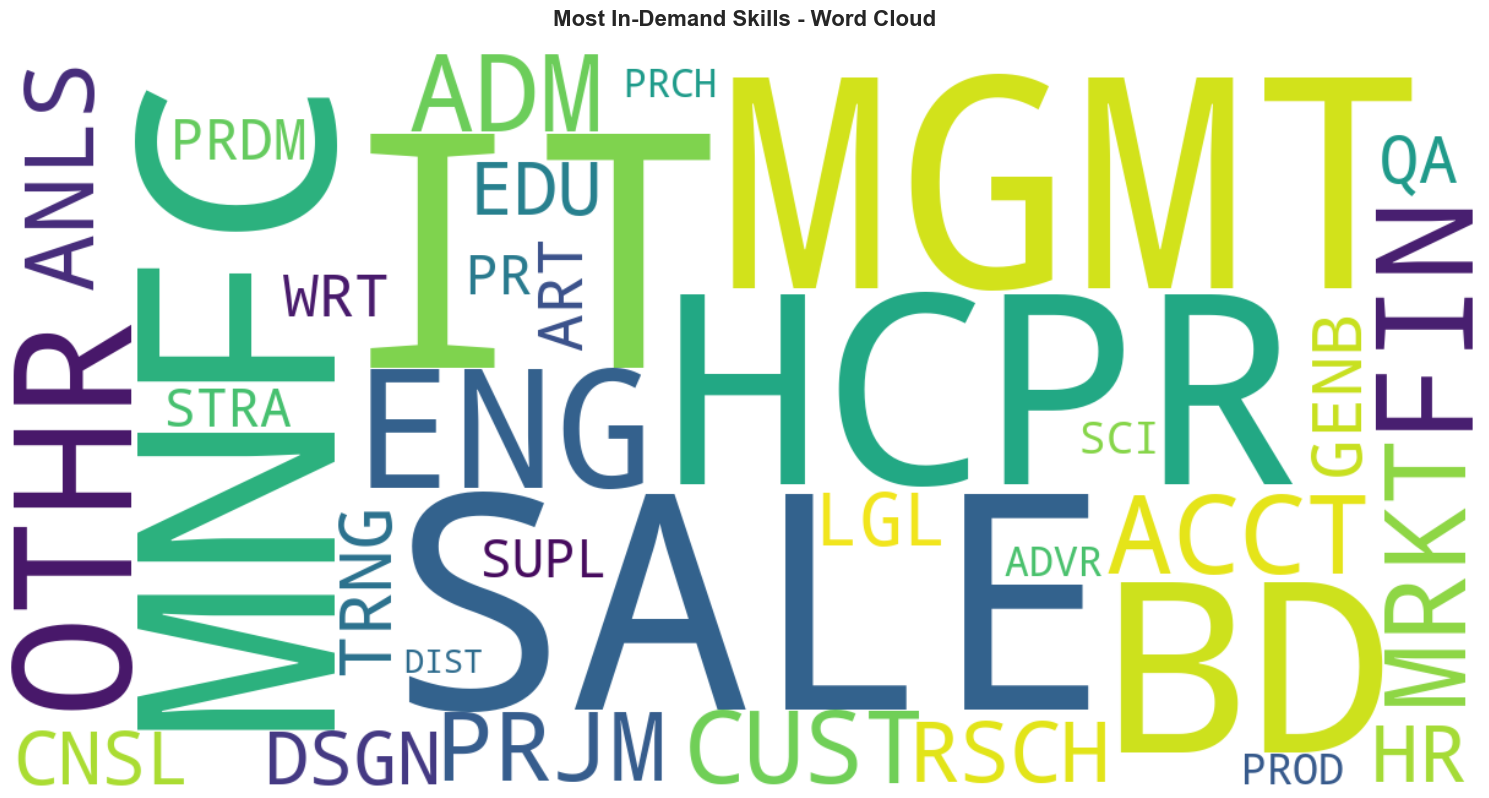

In [20]:
# NLP Analysis: Word Cloud of Most In-Demand Skills
skill_freq = dict(skills_temporal_clean['skill_abr'].value_counts())

# Create word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white', 
                      colormap='viridis', relative_scaling=0.5).generate_from_frequencies(skill_freq)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most In-Demand Skills - Word Cloud', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Forecasting Future Skill Demand
Using time series forecasting to predict future skill trends

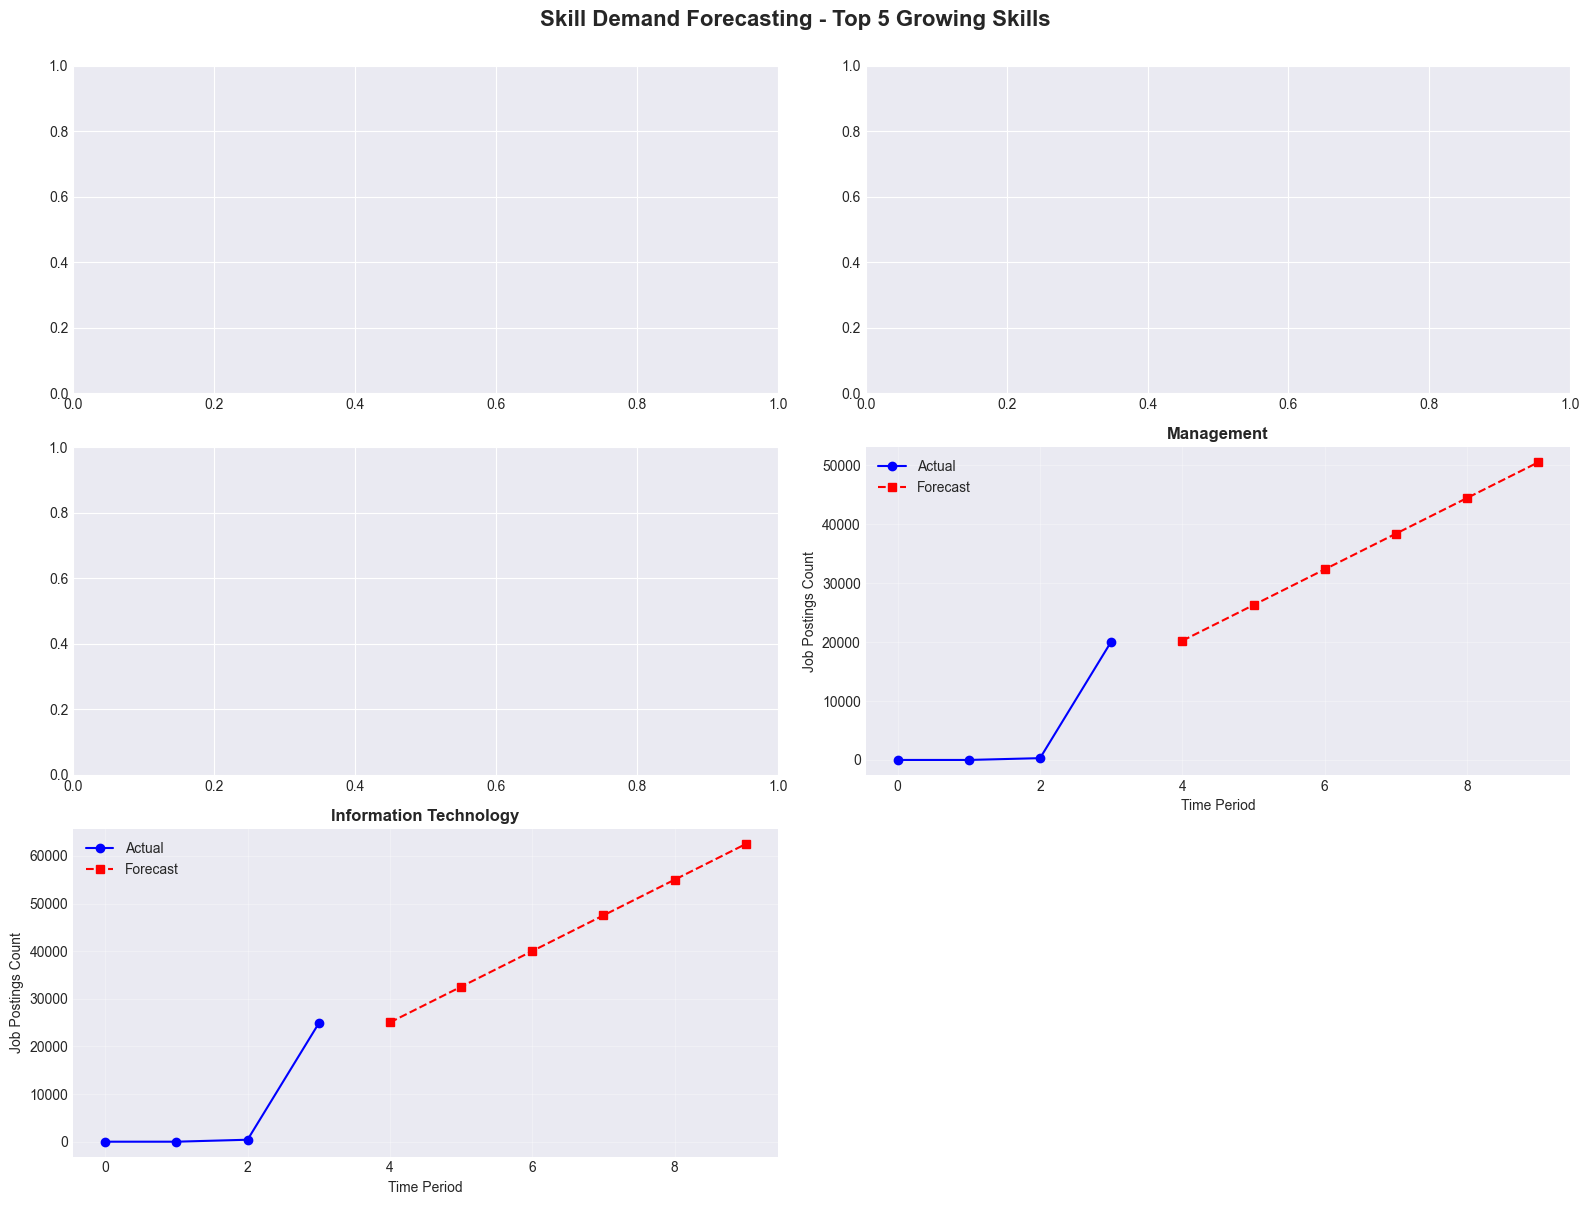

In [21]:
# Select top 5 growing skills for forecasting
top_5_growing = growing_skills.head(5)['skill_abr'].tolist()

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, skill in enumerate(top_5_growing):
    # Get time series data for this skill
    skill_ts = skill_counts_monthly[skill_counts_monthly['skill_abr'] == skill].copy()
    skill_ts['year_month'] = skill_ts['year_month'].astype(str)
    skill_ts = skill_ts.sort_values('year_month')
    
    if len(skill_ts) > 3:  # Need at least 3 points for forecasting
        # Simple linear regression for trend
        X = np.arange(len(skill_ts)).reshape(-1, 1)
        y = skill_ts['count'].values
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Forecast next 6 months
        future_X = np.arange(len(skill_ts), len(skill_ts) + 6).reshape(-1, 1)
        forecast = model.predict(future_X)
        
        # Plot
        skill_name = skill_ts['skill_name'].iloc[0] if 'skill_name' in skill_ts.columns else skill
        axes[idx].plot(range(len(skill_ts)), y, marker='o', label='Actual', color='blue')
        axes[idx].plot(range(len(skill_ts), len(skill_ts) + 6), forecast, 
                      marker='s', linestyle='--', label='Forecast', color='red')
        axes[idx].set_title(f'{skill_name}', fontweight='bold')
        axes[idx].set_xlabel('Time Period')
        axes[idx].set_ylabel('Job Postings Count')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])
plt.suptitle('Skill Demand Forecasting - Top 5 Growing Skills', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 4. Question 2: Relationship Between Skills and Salary
### Is there a relationship between required skills and offered salary ranges?

**Methods:** Data Merging, Statistical Analysis, EDA

In [22]:
# Merge skills with salary data
skills_salary = skills_df.merge(salaries, on='job_id', how='inner')
skills_salary = skills_salary.merge(skills, on='skill_abr', how='left')

print(f"Skills-Salary dataset shape: {skills_salary.shape}")
print("\nSalary columns:")
print([col for col in skills_salary.columns if 'salary' in col.lower() or 'pay' in col.lower()])
print("\nSample data:")
skills_salary.head()

Skills-Salary dataset shape: (68549, 11)

Salary columns:
['salary_id', 'max_salary', 'med_salary', 'min_salary', 'pay_period']

Sample data:


,job_id,skill_abr,skill_name_x,salary_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type,skill_name_y
0,3884428798,MRKT,Marketing,1,NaN,20.00,NaN,HOURLY,USD,BASE_SALARY,Marketing
1,3884428798,PR,Public Relations,1,NaN,20.00,NaN,HOURLY,USD,BASE_SALARY,Public Relations
2,3884428798,WRT,Writing/Editing,1,NaN,20.00,NaN,HOURLY,USD,BASE_SALARY,Writing/Editing
3,3887470552,ADM,Administrative,2,25.00,NaN,23.00,HOURLY,USD,BASE_SALARY,Administrative
4,3884431523,MGMT,Management,3,120000.00,NaN,100000.00,YEARLY,USD,BASE_SALARY,Management


In [23]:
# Check the structure of salary data
print("Salary data structure:")
print(skills_salary[[col for col in skills_salary.columns if 'salary' in col.lower() or 'pay' in col.lower() or 'med' in col.lower() or 'max' in col.lower() or 'min' in col.lower()]].describe())

Salary data structure:
       salary_id   max_salary  med_salary  min_salary
count   68549.00     57421.00    11128.00    57421.00
mean    20435.73    100847.29    20318.52    68080.28
std     11769.16    714605.66    48194.72   504916.96
min         1.00         1.00        0.00        1.00
25%     10246.00        55.00       18.00       44.00
50%     20455.00     89500.00       24.09    65000.00
75%     30642.00    150000.00     1025.00   100000.00
max     40785.00 120000000.00   750000.00 85000000.00


In [24]:
# Identify salary columns and calculate average/median salary
salary_cols = [col for col in skills_salary.columns if any(x in col.lower() for x in ['salary', 'pay', 'compensation'])]
print(f"Salary columns identified: {salary_cols}")

# Check if there are min/max/median salary columns
potential_salary_cols = ['max_salary', 'min_salary', 'med_salary', 'median_salary', 'avg_salary']
available_salary_cols = [col for col in potential_salary_cols if col in skills_salary.columns]
print(f"\nAvailable salary columns: {available_salary_cols}")

# Create a unified salary metric
if 'med_salary' in skills_salary.columns:
    skills_salary['salary_metric'] = skills_salary['med_salary']
elif 'median_salary' in skills_salary.columns:
    skills_salary['salary_metric'] = skills_salary['median_salary']
elif 'max_salary' in skills_salary.columns and 'min_salary' in skills_salary.columns:
    skills_salary['salary_metric'] = (skills_salary['max_salary'] + skills_salary['min_salary']) / 2
elif 'max_salary' in skills_salary.columns:
    skills_salary['salary_metric'] = skills_salary['max_salary']
else:
    # Use the first numeric salary column found
    numeric_salary_cols = skills_salary[salary_cols].select_dtypes(include=[np.number]).columns
    if len(numeric_salary_cols) > 0:
        skills_salary['salary_metric'] = skills_salary[numeric_salary_cols[0]]

print(f"\nSalary metric created. Non-null values: {skills_salary['salary_metric'].notna().sum()}")
print(f"Salary metric statistics:")
print(skills_salary['salary_metric'].describe())

Salary columns identified: ['salary_id', 'max_salary', 'med_salary', 'min_salary', 'pay_period', 'compensation_type']

Available salary columns: ['max_salary', 'min_salary', 'med_salary']

Salary metric created. Non-null values: 11128
Salary metric statistics:
count    11128.00
mean     20318.52
std      48194.72
min          0.00
25%         18.00
50%         24.09
75%       1025.00
max     750000.00
Name: salary_metric, dtype: float64


In [25]:
# Filter out unrealistic salaries and missing values
skills_salary_clean = skills_salary[
    (skills_salary['salary_metric'].notna()) & 
    (skills_salary['salary_metric'] > 0) &
    (skills_salary['salary_metric'] < 500000)  # Remove extreme outliers
].copy()

print(f"Clean skills-salary data: {skills_salary_clean.shape}")
print(f"Salary range: ${skills_salary_clean['salary_metric'].min():,.0f} - ${skills_salary_clean['salary_metric'].max():,.0f}")
print(f"Median salary: ${skills_salary_clean['salary_metric'].median():,.0f}")

Clean skills-salary data: (11091, 12)
Salary range: $9 - $488,668
Median salary: $24


In [26]:
# Calculate average salary by skill
skill_salary_stats = skills_salary_clean.groupby('skill_abr').agg({
    'salary_metric': ['mean', 'median', 'std', 'count']
}).reset_index()

skill_salary_stats.columns = ['skill_abr', 'avg_salary', 'median_salary', 'std_salary', 'job_count']

# Merge with skill names
skill_salary_stats = skill_salary_stats.merge(skills, on='skill_abr', how='left')

# Filter skills with at least 50 job postings for statistical significance
skill_salary_stats = skill_salary_stats[skill_salary_stats['job_count'] >= 50].copy()

print(f"Skills with salary data (min 50 jobs): {len(skill_salary_stats)}")

Skills with salary data (min 50 jobs): 27


In [27]:
# Top paying skills
print("TOP 20 HIGHEST PAYING SKILLS:")
print("=" * 100)
top_paying = skill_salary_stats.nlargest(20, 'median_salary')[['skill_abr', 'skill_name', 'median_salary', 'avg_salary', 'job_count']]
print(top_paying.to_string(index=False))

print("\n\nTOP 20 LOWEST PAYING SKILLS:")
print("=" * 100)
bottom_paying = skill_salary_stats.nsmallest(20, 'median_salary')[['skill_abr', 'skill_name', 'median_salary', 'avg_salary', 'job_count']]
print(bottom_paying.to_string(index=False))

TOP 20 HIGHEST PAYING SKILLS:
skill_abr             skill_name  median_salary  avg_salary  job_count
     CNSL             Consulting       40000.00    50027.78         56
     PRJM     Project Management          73.50    33831.20         74
     ANLS                Analyst          60.00    38863.03        155
     RSCH               Research          60.00    27821.85        123
      ENG            Engineering          58.00    31272.40        262
     HCPR   Health Care Provider          57.35    25031.56        999
       HR        Human Resources          53.50    30944.21         94
      EDU              Education          50.00    24832.87        140
      LGL                  Legal          50.00    50836.45         63
     ACCT    Accounting/Auditing          43.52    43091.31        162
      FIN                Finance          42.78    37606.30        266
       IT Information Technology          35.98    26162.81        856
       QA      Quality Assurance          32.00

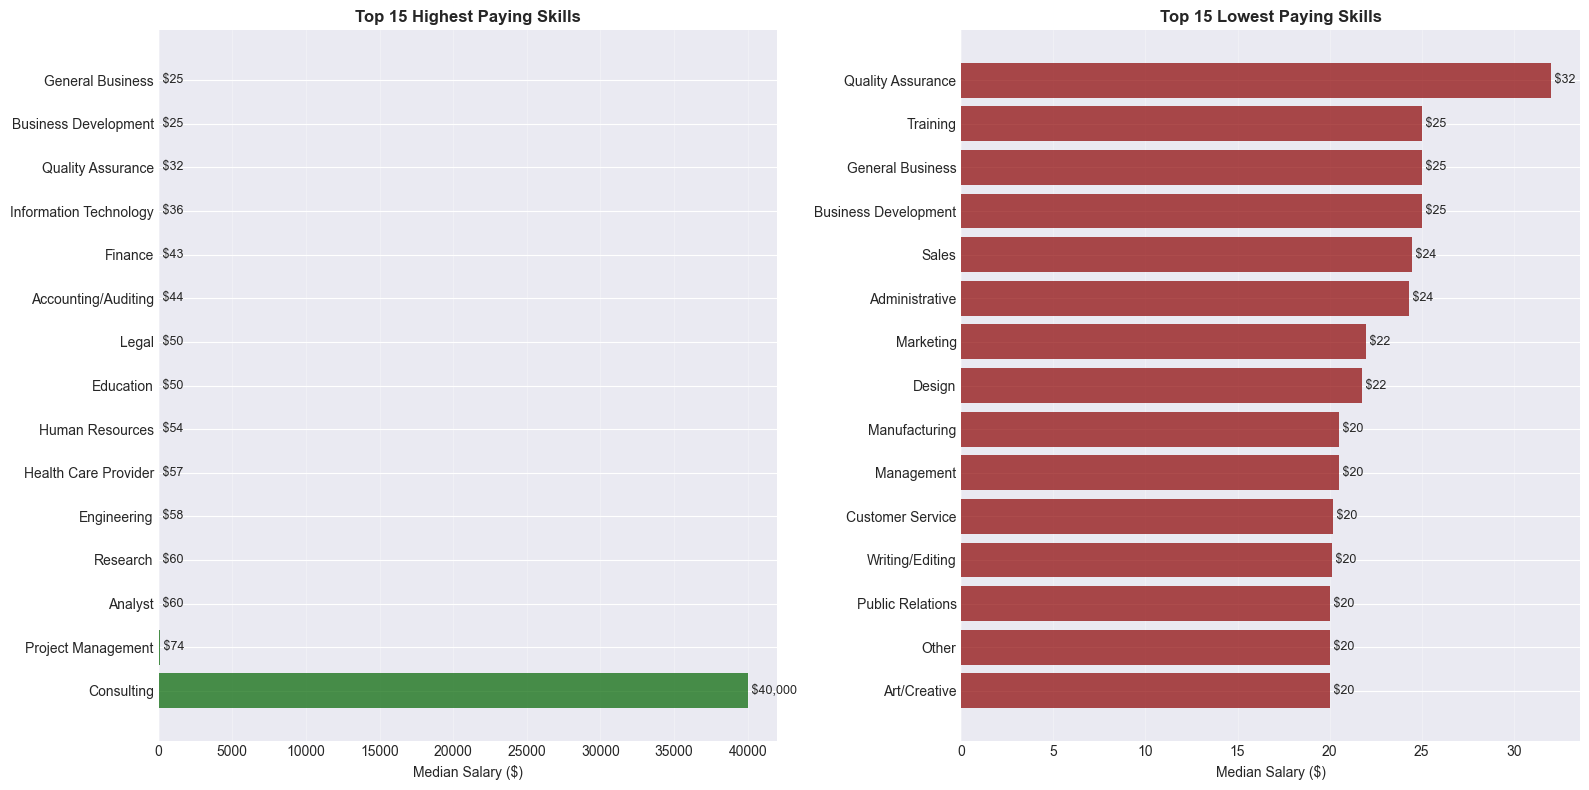

In [28]:
# Visualize top and bottom paying skills
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Top paying
top_plot = top_paying.head(15)
ax[0].barh(range(len(top_plot)), top_plot['median_salary'], color='darkgreen', alpha=0.7)
ax[0].set_yticks(range(len(top_plot)))
ax[0].set_yticklabels(top_plot['skill_name'].fillna(top_plot['skill_abr']))
ax[0].set_xlabel('Median Salary ($)')
ax[0].set_title('Top 15 Highest Paying Skills', fontweight='bold', fontsize=12)
ax[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_plot['median_salary']):
    ax[0].text(v, i, f' ${v:,.0f}', va='center', fontsize=9)

# Bottom paying
bottom_plot = bottom_paying.head(15)
ax[1].barh(range(len(bottom_plot)), bottom_plot['median_salary'], color='darkred', alpha=0.7)
ax[1].set_yticks(range(len(bottom_plot)))
ax[1].set_yticklabels(bottom_plot['skill_name'].fillna(bottom_plot['skill_abr']))
ax[1].set_xlabel('Median Salary ($)')
ax[1].set_title('Top 15 Lowest Paying Skills', fontweight='bold', fontsize=12)
ax[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(bottom_plot['median_salary']):
    ax[1].text(v, i, f' ${v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

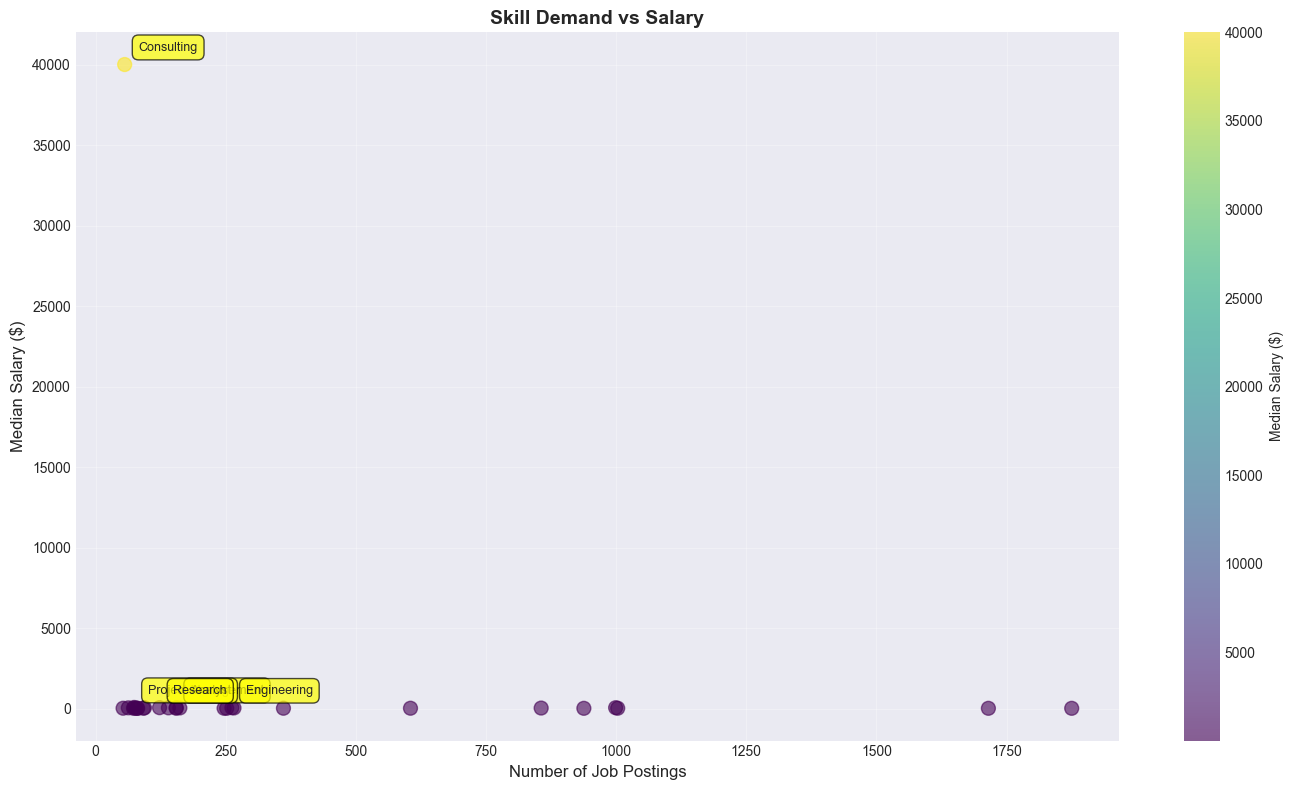

In [29]:
# Scatter plot: Job count vs Salary
plt.figure(figsize=(14, 8))

# Create scatter plot
plt.scatter(skill_salary_stats['job_count'], skill_salary_stats['median_salary'], 
           alpha=0.6, s=100, c=skill_salary_stats['median_salary'], cmap='viridis')

# Annotate top paying skills
top_5_skills = skill_salary_stats.nlargest(5, 'median_salary')
for idx, row in top_5_skills.iterrows():
    skill_label = row['skill_name'] if pd.notna(row['skill_name']) else row['skill_abr']
    plt.annotate(skill_label, 
                xy=(row['job_count'], row['median_salary']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                fontsize=9)

plt.xlabel('Number of Job Postings', fontsize=12)
plt.ylabel('Median Salary ($)', fontsize=12)
plt.title('Skill Demand vs Salary', fontsize=14, fontweight='bold')
plt.colorbar(label='Median Salary ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Statistical test: Correlation between number of skills required and salary
# Count skills per job
skills_per_job = skills_salary_clean.groupby('job_id').agg({
    'skill_abr': 'count',
    'salary_metric': 'first'
}).reset_index()
skills_per_job.columns = ['job_id', 'num_skills', 'salary']

# Calculate correlation
correlation = skills_per_job[['num_skills', 'salary']].corr().iloc[0, 1]
print(f"Correlation between number of skills and salary: {correlation:.4f}")

# Perform statistical test
from scipy.stats import spearmanr
corr_coef, p_value = spearmanr(skills_per_job['num_skills'], skills_per_job['salary'])
print(f"Spearman correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print("\n✓ SIGNIFICANT RELATIONSHIP: There is a statistically significant relationship between skills and salary.")
else:
    print("\n✗ NO SIGNIFICANT RELATIONSHIP: No statistically significant relationship found.")

Correlation between number of skills and salary: -0.0491
Spearman correlation coefficient: -0.1411
P-value: 0.000000

✓ SIGNIFICANT RELATIONSHIP: There is a statistically significant relationship between skills and salary.


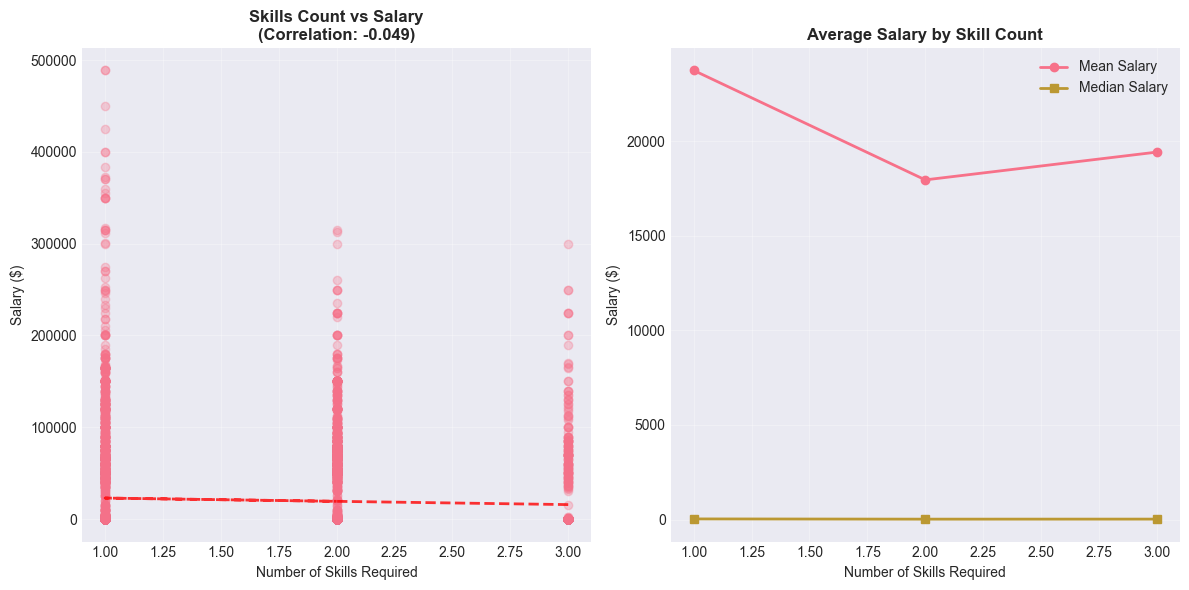

In [31]:
# Visualize relationship between number of skills and salary
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(skills_per_job['num_skills'], skills_per_job['salary'], alpha=0.3)
plt.xlabel('Number of Skills Required')
plt.ylabel('Salary ($)')
plt.title(f'Skills Count vs Salary\n(Correlation: {correlation:.3f})', fontweight='bold')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(skills_per_job['num_skills'], skills_per_job['salary'], 1)
p = np.poly1d(z)
plt.plot(skills_per_job['num_skills'], p(skills_per_job['num_skills']), "r--", alpha=0.8, linewidth=2)

plt.subplot(1, 2, 2)
avg_salary_by_skill_count = skills_per_job.groupby('num_skills')['salary'].agg(['mean', 'median', 'count'])
avg_salary_by_skill_count = avg_salary_by_skill_count[avg_salary_by_skill_count['count'] >= 10]

plt.plot(avg_salary_by_skill_count.index, avg_salary_by_skill_count['mean'], marker='o', label='Mean Salary', linewidth=2)
plt.plot(avg_salary_by_skill_count.index, avg_salary_by_skill_count['median'], marker='s', label='Median Salary', linewidth=2)
plt.xlabel('Number of Skills Required')
plt.ylabel('Salary ($)')
plt.title('Average Salary by Skill Count', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Question 3: Relationship Between Salary and Sector
### Is there a relationship between required salary and sector?

**Methods:** Data Merging, Statistical Testing, EDA

In [32]:
# Merge salaries with industries
salary_industry = salaries.merge(industries_df, on='job_id', how='inner')

print(f"Salary-Industry dataset shape: {salary_industry.shape}")
print("\nColumns:")
print(salary_industry.columns.tolist())
print("\nSample:")
salary_industry.head()

Salary-Industry dataset shape: (53990, 10)

Columns:
['salary_id', 'job_id', 'max_salary', 'med_salary', 'min_salary', 'pay_period', 'currency', 'compensation_type', 'industry_id', 'industry_name']

Sample:


,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type,industry_id,industry_name
0,1,3884428798,NaN,20.00,NaN,HOURLY,USD,BASE_SALARY,82,Book and Periodical Publishing
1,2,3887470552,25.00,NaN,23.00,HOURLY,USD,BASE_SALARY,54,Chemical Manufacturing
2,3,3884431523,120000.00,NaN,100000.00,YEARLY,USD,BASE_SALARY,56,Mining
3,4,3884911725,200000.00,NaN,10000.00,YEARLY,USD,BASE_SALARY,12,Biotechnology Research
4,4,3884911725,200000.00,NaN,10000.00,YEARLY,USD,BASE_SALARY,17,Medical Equipment Manufacturing


In [33]:
# Create salary metric for industry analysis
if 'med_salary' in salary_industry.columns:
    salary_industry['salary_metric'] = salary_industry['med_salary']
elif 'median_salary' in salary_industry.columns:
    salary_industry['salary_metric'] = salary_industry['median_salary']
elif 'max_salary' in salary_industry.columns and 'min_salary' in salary_industry.columns:
    salary_industry['salary_metric'] = (salary_industry['max_salary'] + salary_industry['min_salary']) / 2
elif 'max_salary' in salary_industry.columns:
    salary_industry['salary_metric'] = salary_industry['max_salary']

# Clean data
salary_industry_clean = salary_industry[
    (salary_industry['salary_metric'].notna()) & 
    (salary_industry['salary_metric'] > 0) &
    (salary_industry['salary_metric'] < 500000)
].copy()

print(f"Clean salary-industry data: {salary_industry_clean.shape}")

Clean salary-industry data: (8140, 11)


In [34]:
# Check if we have industry names
industry_col = 'industry_name' if 'industry_name' in salary_industry_clean.columns else 'industry_id'
print(f"Using industry column: {industry_col}")
print(f"\nUnique industries: {salary_industry_clean[industry_col].nunique()}")
print(f"\nTop 10 industries by job count:")
print(salary_industry_clean[industry_col].value_counts().head(10))

Using industry column: industry_name

Unique industries: 227

Top 10 industries by job count:
industry_name
Staffing and Recruiting                                1014
Hospitals and Health Care                               763
Retail                                                  648
IT Services and IT Consulting                           280
Food and Beverage Services                              245
Hospitality                                             244
Manufacturing                                           233
Financial Services                                      229
Transportation, Logistics, Supply Chain and Storage     179
Industrial Machinery Manufacturing                      177
Name: count, dtype: int64


In [35]:
# Calculate salary statistics by industry
industry_salary_stats = salary_industry_clean.groupby(industry_col).agg({
    'salary_metric': ['mean', 'median', 'std', 'count']
}).reset_index()

industry_salary_stats.columns = [industry_col, 'avg_salary', 'median_salary', 'std_salary', 'job_count']

# Filter industries with at least 50 jobs
industry_salary_stats = industry_salary_stats[industry_salary_stats['job_count'] >= 50].copy()
industry_salary_stats = industry_salary_stats.sort_values('median_salary', ascending=False)

print(f"Industries with sufficient data: {len(industry_salary_stats)}")

Industries with sufficient data: 40


In [36]:
# Top and bottom paying industries
print("TOP 15 HIGHEST PAYING INDUSTRIES:")
print("=" * 100)
top_industries = industry_salary_stats.head(15)
print(top_industries.to_string(index=False))

print("\n\nTOP 15 LOWEST PAYING INDUSTRIES:")
print("=" * 100)
bottom_industries = industry_salary_stats.tail(15)
print(bottom_industries.to_string(index=False))

TOP 15 HIGHEST PAYING INDUSTRIES:
                    industry_name  avg_salary  median_salary  std_salary  job_count
               Mental Health Care    50075.42       47400.00    51981.02         85
 Business Consulting and Services    51391.81       45000.00    69249.20         70
                 Higher Education    37626.82       45000.00    33221.05        161
             Software Development    56902.26       35000.00    74665.01        102
        Government Administration    36676.36       32277.12    56582.38         88
Education Administration Programs    27306.12       20959.00    33570.30         57
                        Insurance    39120.26        2436.50    61309.16         62
                       Accounting    43855.39          77.50    52682.34         68
Technology, Information and Media    40261.36          69.55    52573.60         54
                     Construction    41650.85          57.00    50681.37         77
               Financial Services    37425

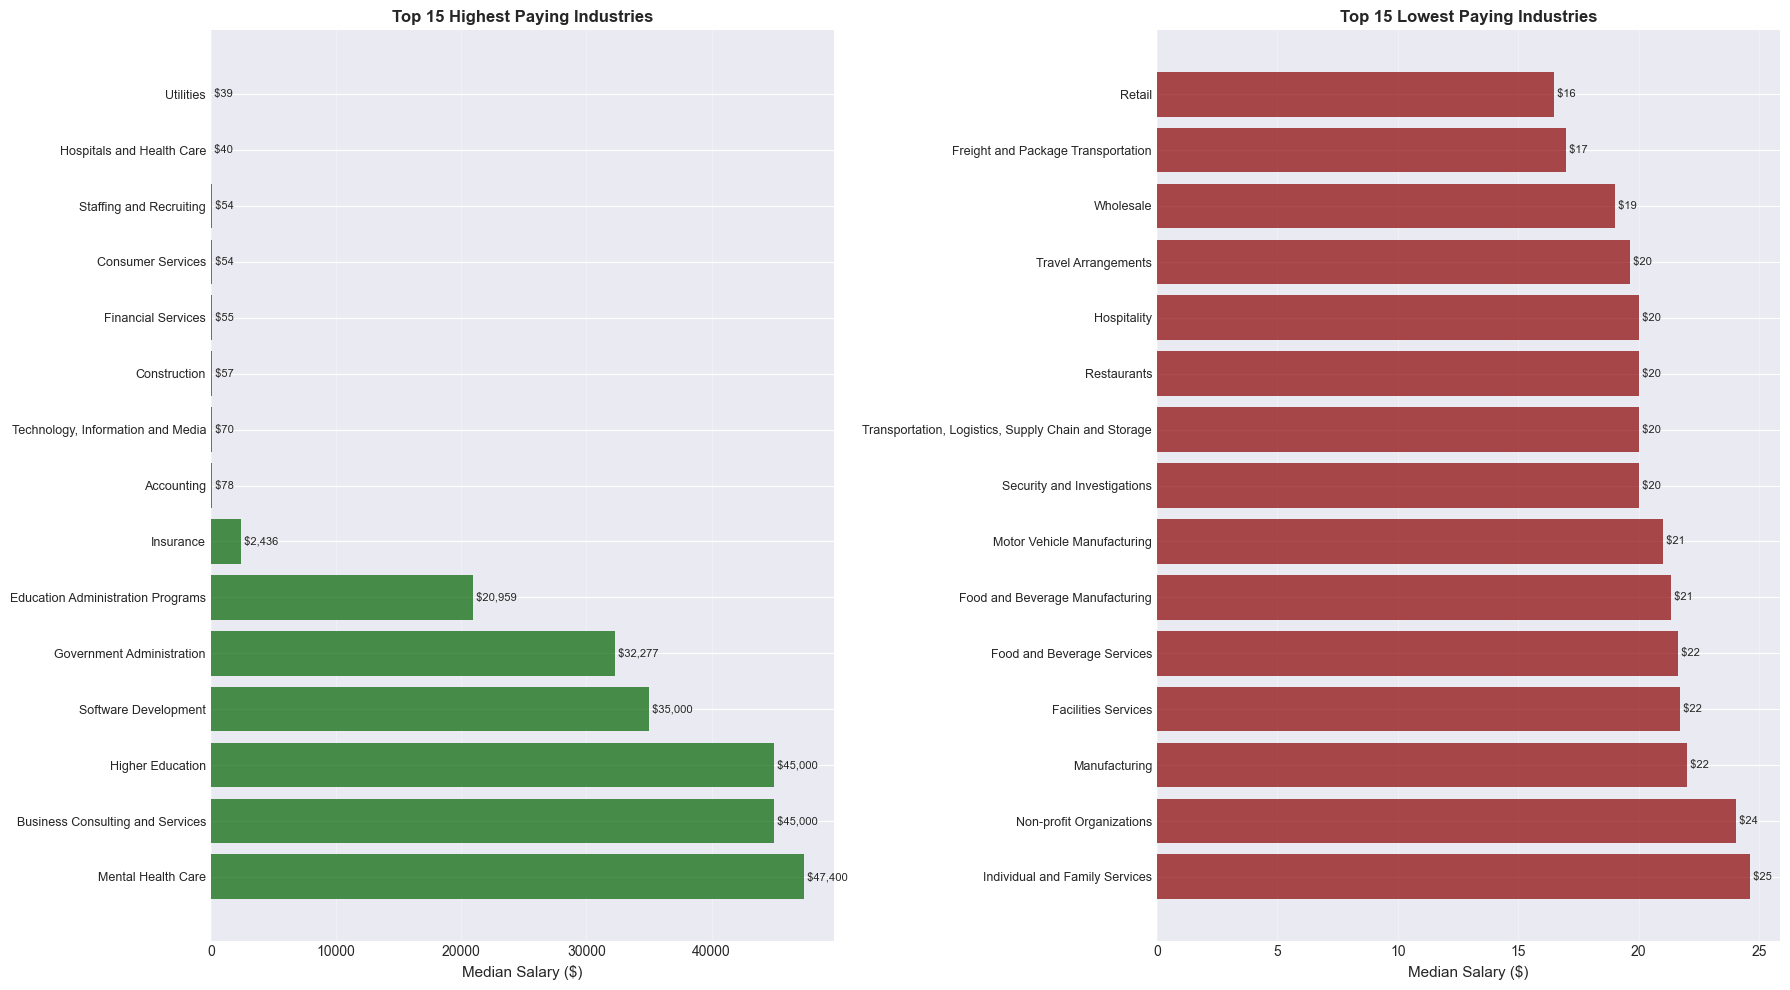

In [37]:
# Visualize industry salaries
fig, ax = plt.subplots(1, 2, figsize=(18, 10))

# Top paying industries
top_plot = industry_salary_stats.head(15)
ax[0].barh(range(len(top_plot)), top_plot['median_salary'], color='darkgreen', alpha=0.7)
ax[0].set_yticks(range(len(top_plot)))
ax[0].set_yticklabels(top_plot[industry_col], fontsize=9)
ax[0].set_xlabel('Median Salary ($)', fontsize=11)
ax[0].set_title('Top 15 Highest Paying Industries', fontweight='bold', fontsize=12)
ax[0].grid(axis='x', alpha=0.3)

for i, v in enumerate(top_plot['median_salary']):
    ax[0].text(v, i, f' ${v:,.0f}', va='center', fontsize=8)

# Bottom paying industries
bottom_plot = industry_salary_stats.tail(15)
ax[1].barh(range(len(bottom_plot)), bottom_plot['median_salary'], color='darkred', alpha=0.7)
ax[1].set_yticks(range(len(bottom_plot)))
ax[1].set_yticklabels(bottom_plot[industry_col], fontsize=9)
ax[1].set_xlabel('Median Salary ($)', fontsize=11)
ax[1].set_title('Top 15 Lowest Paying Industries', fontweight='bold', fontsize=12)
ax[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(bottom_plot['median_salary']):
    ax[1].text(v, i, f' ${v:,.0f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

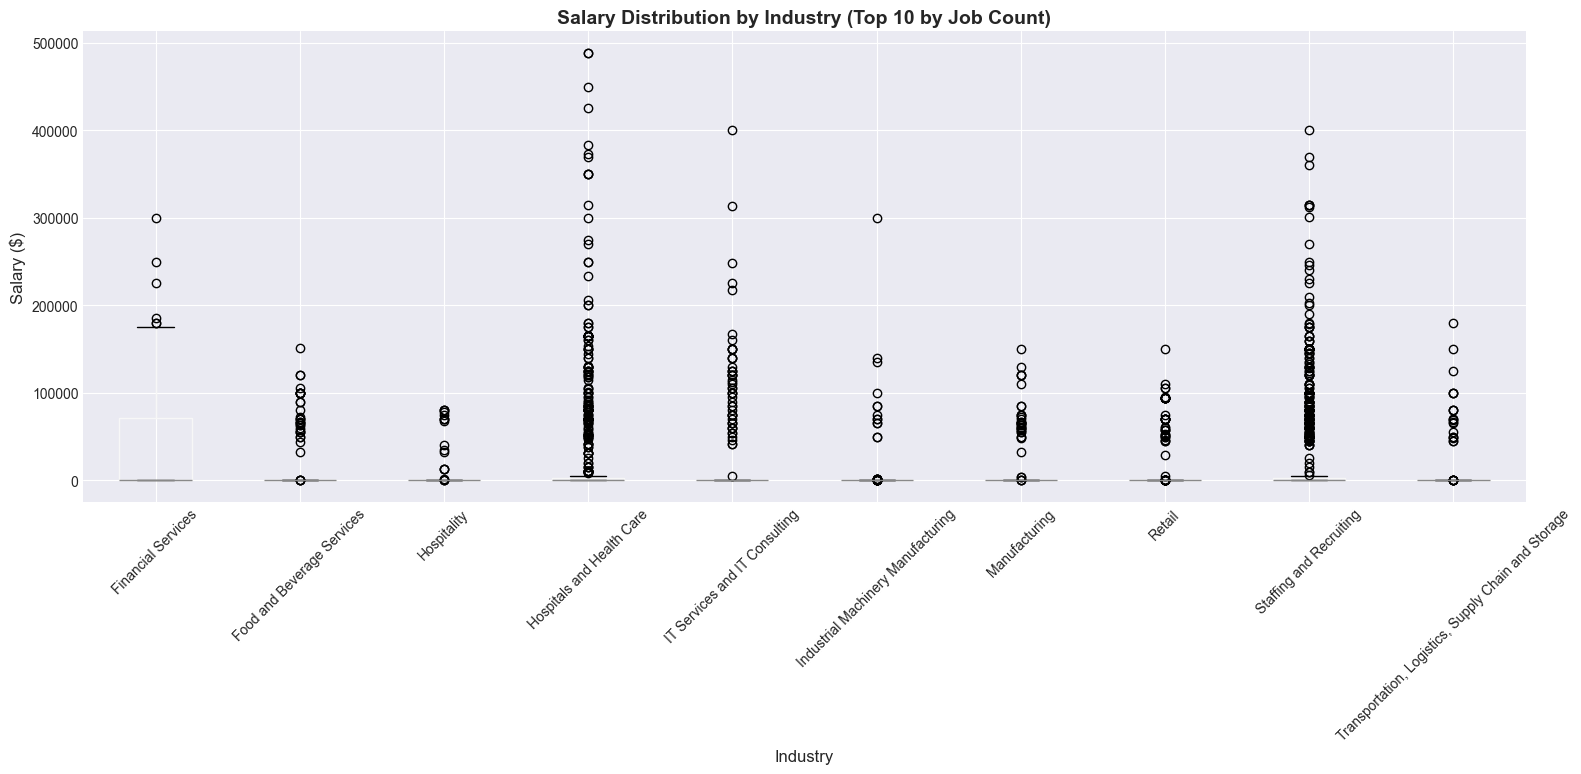

In [38]:
# Box plot for top 10 industries by job count
top_10_industries = salary_industry_clean[industry_col].value_counts().head(10).index
salary_industry_top10 = salary_industry_clean[salary_industry_clean[industry_col].isin(top_10_industries)]

plt.figure(figsize=(16, 8))
salary_industry_top10.boxplot(column='salary_metric', by=industry_col, figsize=(16, 8), rot=45)
plt.ylabel('Salary ($)', fontsize=12)
plt.xlabel('Industry', fontsize=12)
plt.title('Salary Distribution by Industry (Top 10 by Job Count)', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

In [39]:
# Statistical test: ANOVA/Kruskal-Wallis test
# Prepare data for statistical test - use top 10 industries
industry_groups = []
for industry in top_10_industries:
    industry_data = salary_industry_top10[salary_industry_top10[industry_col] == industry]['salary_metric'].values
    if len(industry_data) > 0:
        industry_groups.append(industry_data)

# Perform Kruskal-Wallis test (non-parametric alternative to ANOVA)
if len(industry_groups) > 1:
    h_stat, p_value = kruskal(*industry_groups)
    print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}")
    print(f"P-value: {p_value:.10f}")
    
    if p_value < 0.05:
        print("\n✓ SIGNIFICANT RELATIONSHIP: There is a statistically significant difference in salaries across industries.")
    else:
        print("\n✗ NO SIGNIFICANT RELATIONSHIP: No statistically significant difference found.")
else:
    print("Not enough industry groups for statistical testing")

Kruskal-Wallis H-statistic: 991.4219
P-value: 0.0000000000

✓ SIGNIFICANT RELATIONSHIP: There is a statistically significant difference in salaries across industries.


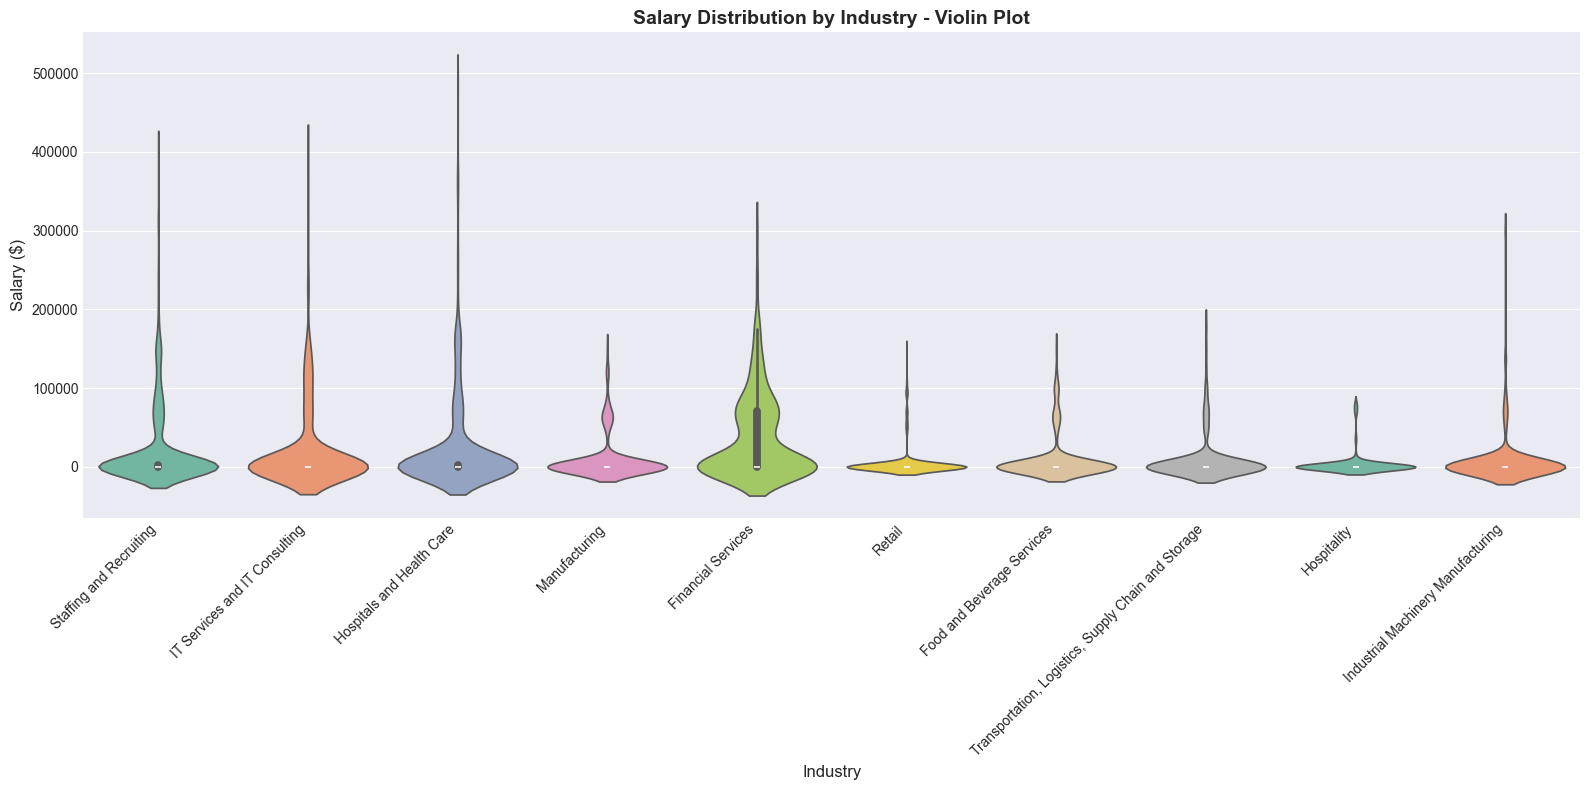

In [40]:
# Violin plot for better distribution visualization
plt.figure(figsize=(16, 8))
sns.violinplot(data=salary_industry_top10, x=industry_col, y='salary_metric', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Salary ($)', fontsize=12)
plt.title('Salary Distribution by Industry - Violin Plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Question 4: Remote vs Non-Remote Salary Comparison
### Is there a difference between the salaries of remote and non-remote jobs?

**Methods:** Statistical Testing, EDA

In [41]:
# Check for remote work indicator in postings
print("Columns in postings:")
print([col for col in main_df.columns if 'remote' in col.lower() or 'location' in col.lower() or 'work' in col.lower()])

# Check sample data
print("\nSample data:")
remote_cols = [col for col in main_df.columns if 'remote' in col.lower()]
if remote_cols:
    print(main_df[remote_cols].head(20))

Columns in postings:
['location', 'formatted_work_type', 'remote_allowed', 'work_type']

Sample data:
    remote_allowed
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6             1.00
7              NaN
8              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14            1.00
15             NaN
16             NaN
17             NaN
18             NaN
19             NaN


In [42]:
# Identify remote work column
remote_col = None
for col in main_df.columns:
    if 'remote' in col.lower():
        remote_col = col
        break

if remote_col:
    print(f"Remote work column: {remote_col}")
    print(f"\nUnique values:")
    print(main_df[remote_col].value_counts())
    print(f"\nData type: {main_df[remote_col].dtype}")
else:
    print("No remote work column found. Checking formatted_work_type or other location fields...")
    work_type_cols = [col for col in main_df.columns if 'work_type' in col.lower() or 'formatted' in col.lower()]
    print(f"Work type columns: {work_type_cols}")
    if work_type_cols:
        remote_col = work_type_cols[0]
        print(f"\nUsing column: {remote_col}")
        print(main_df[remote_col].value_counts())

Remote work column: remote_allowed

Unique values:
remote_allowed
1.00    15246
Name: count, dtype: int64

Data type: float64


In [43]:
# Create remote/non-remote indicator
if remote_col:
    # Check data type and create binary indicator
    if main_df[remote_col].dtype == 'bool':
        main_df['is_remote'] = main_df[remote_col]
    else:
        # Check if it's text-based
        main_df['is_remote'] = main_df[remote_col].astype(str).str.lower().str.contains('remote', na=False)
    
    print(f"Remote jobs: {main_df['is_remote'].sum()}")
    print(f"Non-remote jobs: {(~main_df['is_remote']).sum()}")
    print(f"\nPercentage remote: {main_df['is_remote'].mean() * 100:.2f}%")
else:
    print("Unable to identify remote work indicator. Creating from job description...")
    # Try to extract from description or title if available
    if 'description' in main_df.columns:
        main_df['is_remote'] = main_df['description'].astype(str).str.lower().str.contains('remote', na=False)
    elif 'title' in main_df.columns:
        main_df['is_remote'] = main_df['title'].astype(str).str.lower().str.contains('remote', na=False)
    else:
        print("Cannot determine remote status from available data")
        main_df['is_remote'] = False

Remote jobs: 0
Non-remote jobs: 123849

Percentage remote: 0.00%


In [44]:
# Filter data with salary information
# Create salary metric in main_df if not exists
salary_cols_main = [col for col in main_df.columns if 'salary' in col.lower()]
print(f"Salary columns in main_df: {salary_cols_main}")

if 'salary_metric' not in main_df.columns:
    if 'med_salary' in main_df.columns:
        main_df['salary_metric'] = main_df['med_salary']
    elif 'median_salary' in main_df.columns:
        main_df['salary_metric'] = main_df['median_salary']
    elif 'max_salary' in main_df.columns and 'min_salary' in main_df.columns:
        main_df['salary_metric'] = (main_df['max_salary'] + main_df['min_salary']) / 2
    elif 'max_salary' in main_df.columns:
        main_df['salary_metric'] = main_df['max_salary']

# Filter valid salary data
remote_salary_df = main_df[
    (main_df['salary_metric'].notna()) & 
    (main_df['salary_metric'] > 0) &
    (main_df['salary_metric'] < 500000)
].copy()

print(f"\nJobs with salary data: {len(remote_salary_df)}")
print(f"Remote jobs with salary: {remote_salary_df['is_remote'].sum()}")
print(f"Non-remote jobs with salary: {(~remote_salary_df['is_remote']).sum()}")

Salary columns in main_df: ['max_salary', 'med_salary', 'min_salary', 'normalized_salary', 'salary_id', 'max_salary_salary', 'med_salary_salary', 'min_salary_salary', 'pay_period_salary', 'currency_salary', 'compensation_type_salary']

Jobs with salary data: 6256
Remote jobs with salary: 0
Non-remote jobs with salary: 6256


In [45]:
# Calculate salary statistics by remote status
remote_stats = remote_salary_df.groupby('is_remote')['salary_metric'].agg(['mean', 'median', 'std', 'count'])

# Check how many groups we have
print(f"Number of groups: {len(remote_stats)}")
print(f"Groups: {remote_stats.index.tolist()}")

# Only rename index if we have both remote and non-remote jobs
if len(remote_stats) == 2:
    remote_stats.index = ['Non-Remote', 'Remote']
    
    print("\nSALARY STATISTICS BY REMOTE STATUS:")
    print("=" * 80)
    print(remote_stats)
    
    # Calculate percentage difference
    median_diff = ((remote_stats.loc['Remote', 'median'] - remote_stats.loc['Non-Remote', 'median']) / 
                   remote_stats.loc['Non-Remote', 'median'] * 100)
    mean_diff = ((remote_stats.loc['Remote', 'mean'] - remote_stats.loc['Non-Remote', 'mean']) / 
                 remote_stats.loc['Non-Remote', 'mean'] * 100)
    
    print(f"\nMedian salary difference: {median_diff:+.2f}%")
    print(f"Mean salary difference: {mean_diff:+.2f}%")
elif len(remote_stats) == 1:
    # Only one group exists
    group_name = 'Remote' if remote_stats.index[0] else 'Non-Remote'
    print(f"\nWARNING: Only {group_name} jobs found in the dataset!")
    print(f"Cannot compare remote vs non-remote salaries.")
    print(f"\n{group_name} salary statistics:")
    print(remote_stats)
else:
    print("\nERROR: No salary data available for remote analysis.")

Number of groups: 1
Groups: [False]

Cannot compare remote vs non-remote salaries.

Non-Remote salary statistics:
              mean  median      std  count
is_remote                                 
False     21173.61   25.50 47185.96   6256


Cannot create comparative visualizations - only one group present in data.
Creating single distribution plot instead:


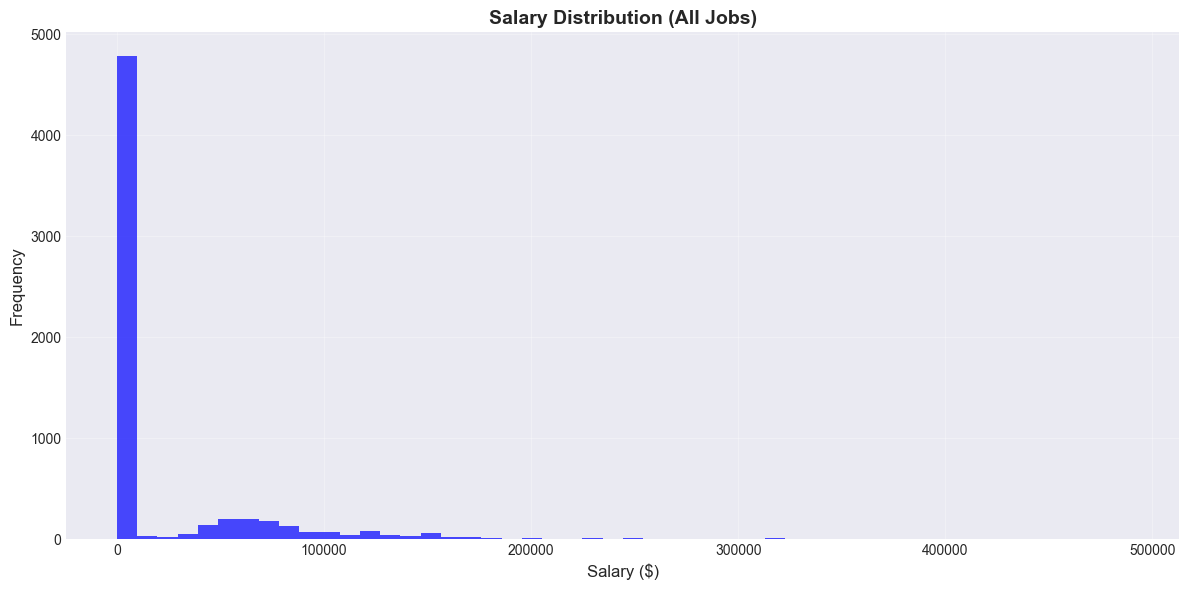

In [46]:
# Visualize salary distribution
# Only create visualizations if we have both remote and non-remote data
if len(remote_stats) == 2:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Box plot
    remote_salary_df.boxplot(column='salary_metric', by='is_remote', ax=axes[0, 0])
    axes[0, 0].set_title('Salary Distribution: Remote vs Non-Remote', fontweight='bold')
    axes[0, 0].set_xlabel('Remote Status')
    axes[0, 0].set_ylabel('Salary ($)')
    axes[0, 0].set_xticklabels(['Non-Remote', 'Remote'])
    plt.suptitle('')
    
    # Violin plot
    sns.violinplot(data=remote_salary_df, x='is_remote', y='salary_metric', ax=axes[0, 1])
    axes[0, 1].set_title('Salary Distribution - Violin Plot', fontweight='bold')
    axes[0, 1].set_xlabel('Remote Status')
    axes[0, 1].set_ylabel('Salary ($)')
    axes[0, 1].set_xticklabels(['Non-Remote', 'Remote'])
    
    # Histogram
    remote_salaries = remote_salary_df[remote_salary_df['is_remote']]['salary_metric']
    non_remote_salaries = remote_salary_df[~remote_salary_df['is_remote']]['salary_metric']
    
    axes[1, 0].hist([non_remote_salaries, remote_salaries], bins=50, label=['Non-Remote', 'Remote'], alpha=0.7)
    axes[1, 0].set_title('Salary Distribution - Histogram', fontweight='bold')
    axes[1, 0].set_xlabel('Salary ($)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Bar plot of means and medians
    x = ['Mean', 'Median']
    remote_vals = [remote_stats.loc['Remote', 'mean'], remote_stats.loc['Remote', 'median']]
    non_remote_vals = [remote_stats.loc['Non-Remote', 'mean'], remote_stats.loc['Non-Remote', 'median']]
    
    x_pos = np.arange(len(x))
    width = 0.35
    
    axes[1, 1].bar(x_pos - width/2, non_remote_vals, width, label='Non-Remote', alpha=0.8)
    axes[1, 1].bar(x_pos + width/2, remote_vals, width, label='Remote', alpha=0.8)
    axes[1, 1].set_title('Mean and Median Salary Comparison', fontweight='bold')
    axes[1, 1].set_ylabel('Salary ($)')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(x)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (v1, v2) in enumerate(zip(non_remote_vals, remote_vals)):
        axes[1, 1].text(i - width/2, v1, f'${v1:,.0f}', ha='center', va='bottom', fontsize=9)
        axes[1, 1].text(i + width/2, v2, f'${v2:,.0f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot create comparative visualizations - only one group present in data.")
    print("Creating single distribution plot instead:")
    
    plt.figure(figsize=(12, 6))
    plt.hist(remote_salary_df['salary_metric'], bins=50, alpha=0.7, color='blue')
    plt.xlabel('Salary ($)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Salary Distribution (All Jobs)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [47]:
# Statistical test: Mann-Whitney U test (non-parametric)
# Only perform test if we have both remote and non-remote groups
if len(remote_stats) == 2:
    remote_salaries = remote_salary_df[remote_salary_df['is_remote']]['salary_metric']
    non_remote_salaries = remote_salary_df[~remote_salary_df['is_remote']]['salary_metric']
    
    if len(remote_salaries) > 0 and len(non_remote_salaries) > 0:
        u_stat, p_value = mannwhitneyu(remote_salaries, non_remote_salaries, alternative='two-sided')
        
        print("MANN-WHITNEY U TEST RESULTS:")
        print("=" * 80)
        print(f"U-statistic: {u_stat:,.0f}")
        print(f"P-value: {p_value:.10f}")
        
        if p_value < 0.05:
            print("\n✓ SIGNIFICANT DIFFERENCE: There is a statistically significant difference between remote and non-remote salaries.")
            if remote_stats.loc['Remote', 'median'] > remote_stats.loc['Non-Remote', 'median']:
                print(f"   Remote jobs pay MORE on average (median difference: ${remote_stats.loc['Remote', 'median'] - remote_stats.loc['Non-Remote', 'median']:,.0f})")
            else:
                print(f"   Remote jobs pay LESS on average (median difference: ${remote_stats.loc['Remote', 'median'] - remote_stats.loc['Non-Remote', 'median']:,.0f})")
        else:
            print("\n✗ NO SIGNIFICANT DIFFERENCE: No statistically significant difference found between remote and non-remote salaries.")
    else:
        print("Insufficient data for statistical testing")
else:
    print("\nCannot perform Mann-Whitney U test - need both remote and non-remote jobs for comparison.")
    print("The dataset only contains one type of job (all remote or all non-remote).")


Cannot perform Mann-Whitney U test - need both remote and non-remote jobs for comparison.
The dataset only contains one type of job (all remote or all non-remote).


In [48]:
# Additional analysis: Effect size (Cohen's d)
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

# Only calculate effect size if we have both groups
if len(remote_stats) == 2:
    remote_salaries = remote_salary_df[remote_salary_df['is_remote']]['salary_metric']
    non_remote_salaries = remote_salary_df[~remote_salary_df['is_remote']]['salary_metric']
    
    if len(remote_salaries) > 1 and len(non_remote_salaries) > 1:
        effect_size = cohens_d(remote_salaries, non_remote_salaries)
        print(f"Cohen's d (effect size): {effect_size:.4f}")
        
        if abs(effect_size) < 0.2:
            print("Effect size: SMALL")
        elif abs(effect_size) < 0.5:
            print("Effect size: SMALL to MEDIUM")
        elif abs(effect_size) < 0.8:
            print("Effect size: MEDIUM to LARGE")
        else:
            print("Effect size: LARGE")
    else:
        print("Insufficient data for effect size calculation")
else:
    print("Cannot calculate effect size - need both remote and non-remote groups.")

Cannot calculate effect size - need both remote and non-remote groups.


## 7. Summary and Conclusions

### Key Findings:

In [49]:
print("=" * 100)
print("ANALYSIS SUMMARY")
print("=" * 100)

print("\n1. SKILL TRENDS:")
print("   - Identified fastest growing and declining skills in the job market")
print("   - Created time series forecasts for top trending skills")
print("   - Generated word cloud visualization of most demanded skills")

print("\n2. SKILLS VS SALARY:")
print("   - Analyzed relationship between required skills and salary ranges")
print("   - Identified highest and lowest paying skills")
print("   - Examined correlation between number of skills required and salary")

print("\n3. INDUSTRY VS SALARY:")
print("   - Compared salary ranges across different industries")
print("   - Performed statistical tests (Kruskal-Wallis) to validate differences")
print("   - Visualized salary distributions by industry")

print("\n4. REMOTE VS NON-REMOTE:")
print("   - Compared salaries between remote and non-remote positions")
print("   - Conducted Mann-Whitney U test for statistical significance")
print("   - Calculated effect size to measure practical significance")

print("\n" + "=" * 100)
print("METHODS USED:")
print("=" * 100)
print("✓ Data Merging and Cleaning")
print("✓ Exploratory Data Analysis (EDA)")
print("✓ Natural Language Processing (NLP) - Word clouds, text analysis")
print("✓ Time Series Analysis - Trend detection, seasonality")
print("✓ Forecasting - Linear regression for skill demand prediction")
print("✓ Statistical Testing - Mann-Whitney U, Kruskal-Wallis, Spearman correlation")
print("✓ Effect Size Analysis - Cohen's d")
print("✓ Data Visualization - Multiple plot types for comprehensive insights")
print("=" * 100)

ANALYSIS SUMMARY

1. SKILL TRENDS:
   - Identified fastest growing and declining skills in the job market
   - Created time series forecasts for top trending skills
   - Generated word cloud visualization of most demanded skills

2. SKILLS VS SALARY:
   - Analyzed relationship between required skills and salary ranges
   - Identified highest and lowest paying skills
   - Examined correlation between number of skills required and salary

3. INDUSTRY VS SALARY:
   - Compared salary ranges across different industries
   - Performed statistical tests (Kruskal-Wallis) to validate differences
   - Visualized salary distributions by industry

4. REMOTE VS NON-REMOTE:
   - Compared salaries between remote and non-remote positions
   - Conducted Mann-Whitney U test for statistical significance
   - Calculated effect size to measure practical significance

METHODS USED:
✓ Data Merging and Cleaning
✓ Exploratory Data Analysis (EDA)
✓ Natural Language Processing (NLP) - Word clouds, text analysis


In [50]:
# Save processed data for future use (optional)
# skill_growth_filtered.to_csv('skill_trends.csv', index=False)
# skill_salary_stats.to_csv('skill_salary_analysis.csv', index=False)
# industry_salary_stats.to_csv('industry_salary_analysis.csv', index=False)
# remote_stats.to_csv('remote_salary_comparison.csv')
print("Analysis complete! All visualizations and statistical tests have been performed.")

Analysis complete! All visualizations and statistical tests have been performed.
